# Problem Description

In this project, we are tasked with building a deep learning model to classify microscopy images of cells as either infected or uninfected. The dataset consists of thousands of 96x96 color images, each labeled as 0 (uninfected) or 1 (infected). The images are provided in separate training and test folders, with corresponding labels for the training set.

The main challenges include handling a large dataset, preventing overfitting, and achieving high classification accuracy. Data augmentation and regularization techniques are essential to improve the model's generalization.

# Goal

The goal is to develop a robust convolutional neural network (CNN) using TensorFlow/Keras that can accurately predict the infection status of unseen cell images. The model should be trained, validated, and evaluated using appropriate metrics such as accuracy, precision, recall, and F1 score. Finally, the trained model will be used to generate predictions for the test set, and the results will be exported in a format suitable for submission.

# Importing Libraries:

In [ ]:
import tensorflow as tf
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

/Users/aliali/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Enabling mixed precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy set:", mixed_precision.global_policy())

Mixed precision policy set: <DTypePolicy "mixed_float16">


In [3]:
print("TensorFlow version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"Num GPUs Available: {len(gpu_devices)}")
    for device in gpu_devices:
        print(f"Device name: {device.name}, Type: {device.device_type}")
    # Optionally, set memory growth to True for the GPU.
    # This prevents TensorFlow from allocating all GPU memory at once.
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print("Memory growth set for GPU.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("GPU not available. TensorFlow will use CPU.")

TensorFlow version: 2.16.2
Num GPUs Available: 1
Device name: /physical_device:GPU:0, Type: GPU
Memory growth set for GPU.


# Importing Data:

In [4]:
# Set paths to training and test data
train_path = 'train/'
test_path = 'test/'

df = pd.read_csv("train_labels.csv")
df['path'] = train_path + df['id'] + '.tif'

# Display the first three entries
training_size = len(df)
print(f"Training size: {training_size}")
print("First three entries of the DataFrame:")
df.head(3)

Training size: 220025
First three entries of the DataFrame:


,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,train/f38a6374c348f90b587e046aac6079959adf3835...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,train/c18f2d887b7ae4f6742ee445113fa1aef383ed77...
2,755db6279dae599ebb4d39a9123cce439965282d,0,train/755db6279dae599ebb4d39a9123cce439965282d...


In [5]:
img = cv2.imread(df.iloc[0]['path'])
print("Image shape:", img.shape)  # (height, width, channels)

Image shape: (96, 96, 3)


In [6]:
def load_data(N, df):
    """Loads N images and their labels from the dataframe df."""
    X = np.zeros([N, 96, 96, 3], dtype=np.uint8)
    y = df['label'].to_numpy()[:N]
    for i, row in enumerate(tqdm(df.itertuples(), total=N, desc="Loading images")):
        if i == N:
            break
        img = cv2.imread(row.path)
        if img is not None:
            X[i] = img
        else:
            print(f"Warning: Failed to load image at {row.path}")
    return X, y

In [7]:
N = 120000
df_shuffled = df.sample(frac=1, random_state=2).reset_index(drop=True)
X, y = load_data(N, df_shuffled)

print("Shape of image data (X):", X.shape)
print("Shape of labels (y):", y.shape)

Loading images:   0%|          | 0/120000 [00:00<?, ?it/s]

Shape of image data (X): (120000, 96, 96, 3)
Shape of labels (y): (120000,)


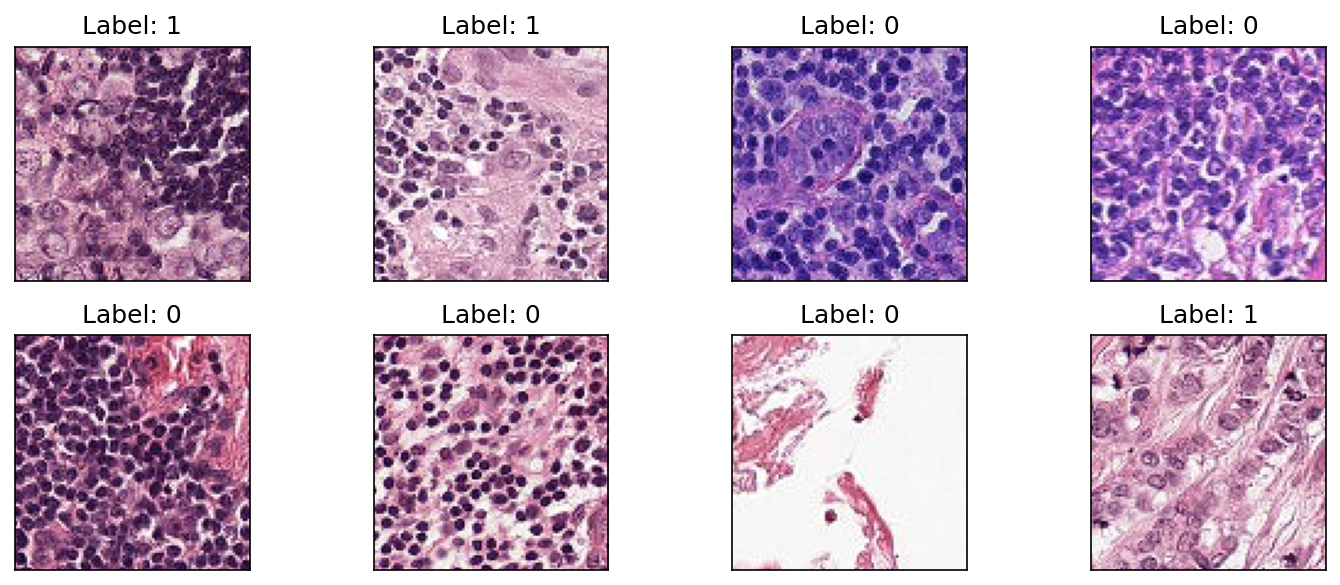

In [8]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100)  # For reproducibility
num_images = 8
for plotNr, idx in enumerate(np.random.randint(0, N, num_images)):
    ax = fig.add_subplot(2, num_images // 2, plotNr + 1, xticks=[], yticks=[])
    img = X[idx]
    # Handle grayscale images if any
    if img.ndim == 2 or img.shape[2] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        image_rgb = img[:, :, ::-1]  # Convert BGR to RGB
        plt.imshow(image_rgb)
    ax.set_title(f'Label: {y[idx]}')
plt.tight_layout()
plt.show()

In [9]:
# Normalize the images
X = X.astype(np.float16) / 255.0


# Exploratory Data Analysis (EDA) on imported images


## 1. Display basic info about the image dataset

In [10]:
print(f"Number of images loaded: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]} (Height, Width, Channels)")
print(f"Number of labels: {len(np.unique(y))}")
print(f"Label distribution:\n{pd.Series(y).value_counts()}")

Number of images loaded: 120000
Image shape: (96, 96, 3) (Height, Width, Channels)
Number of labels: 2
Label distribution:
0    71473
1    48527
Name: count, dtype: int64


# Setting up the Model

## Splitting data:

In [11]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
def data_generator(X, y):
    for img, label in zip(X, y):
        yield img, label

batch_size = 128

train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float16),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val, y_val),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float16),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

2025-06-23 14:17:15.214013: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-23 14:17:15.215234: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-23 14:17:15.215238: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-23 14:17:15.215487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-23 14:17:15.215567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model Training:

In [13]:
# --- 1. TUNED PARAMETERS ---
# Reduced model capacity to start simple. It's easier to add complexity
# than to fight overfitting in a model that is too large.
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
# Reduced dropout rates to more conventional starting points.
dropout_conv = 0.2
dropout_dense = 0.3
dense_units = 128

# --- 2. INITIALIZE THE MODEL ---
model = Sequential()

# --- 3. ADD DATA AUGMENTATION AS THE FIRST LAYER ---
# This is the most critical addition for reducing overfitting in vision tasks.
model.add(layers.Input(shape=(96, 96, 3))) # Explicit Input layer is good practice
# model.add(layers.RandomFlip("horizontal"))
# model.add(layers.RandomRotation(0.05))
# model.add(layers.RandomZoom(0.05))


#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#output layer
model.add(Dense(1, activation="sigmoid"))

# --- COMPILE THE MODEL ---
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.0005), 
              metrics=['accuracy'])
# model.summary()

In [14]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Set to True to save only weights
    monitor='val_accuracy',     # The metric to monitor
    mode='max',                 # 'max' for accuracy, 'min' for loss
    save_best_only=True)      # Only save a model if `val_accuracy` is the best it has seen so far.

early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=4,              # epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # or 'val_accuracy'
    factor=0.5,              # reduce learning rate by this factor
    patience=3,              # epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6
)

epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stop, reduce_lr]
)

Epoch 1/20


2025-06-23 14:17:17.809442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


    750/Unknown 534s 704ms/step - accuracy: 0.8094 - loss: 0.4323

2025-06-23 14:26:11.240519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 14:26:11.241129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All_7/_182]]
2025-06-23 14:26:11.241177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 14:26:11.241191: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16557620436253836465
2025-06-23 14:26:11.241214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5963805348586159508
2025-06-23 14:26:11.241238: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1342114384139

750/750 ━━━━━━━━━━━━━━━━━━━━ 557s 734ms/step - accuracy: 0.8094 - loss: 0.4323 - val_accuracy: 0.7516 - val_loss: 0.5199 - learning_rate: 5.0000e-04
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.8638 - loss: 0.3225

2025-06-23 14:35:40.948430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All/_168]]
2025-06-23 14:35:40.948843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 14:35:40.948867: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5963805348586159508
2025-06-23 14:35:40.948883: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 14:35:40.948896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 14:35:40.948904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 166291542932691

750/750 ━━━━━━━━━━━━━━━━━━━━ 570s 757ms/step - accuracy: 0.8638 - loss: 0.3225 - val_accuracy: 0.8375 - val_loss: 0.4161 - learning_rate: 5.0000e-04
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.8868 - loss: 0.2774

2025-06-23 14:45:42.269125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_10]]
2025-06-23 14:45:42.269552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 14:45:42.269567: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5963805348586159508
2025-06-23 14:45:42.269572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 14:45:42.269578: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 14:45:42.269581: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16557620436253836465
2025-06

750/750 ━━━━━━━━━━━━━━━━━━━━ 602s 801ms/step - accuracy: 0.8868 - loss: 0.2774 - val_accuracy: 0.7841 - val_loss: 0.5095 - learning_rate: 5.0000e-04
Epoch 4/20


2025-06-23 14:46:05.777514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 14:46:05.777675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 14:46:05.777679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-23 14:46:05.777684: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738707730018676863
2025-06-23 14:46:05.777694: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5659080102210656717
2025-06-23 14:46:05.777698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6489512921385518425
2025-06-23

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9026 - loss: 0.2445

2025-06-23 14:55:53.942271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All_11/_190]]
2025-06-23 14:55:53.942812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 14:55:53.942830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4800955950154087790
2025-06-23 14:55:53.942835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 14:55:53.942843: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17147544773036867871
2025-06-23 14:55:53.942850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 921731207957

750/750 ━━━━━━━━━━━━━━━━━━━━ 615s 817ms/step - accuracy: 0.9026 - loss: 0.2445 - val_accuracy: 0.8532 - val_loss: 0.3895 - learning_rate: 5.0000e-04
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9136 - loss: 0.2200

2025-06-23 15:08:19.761278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/sequential_1/batch_normalization_1/moments/mod/_51]]
2025-06-23 15:08:19.761639: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5963805348586159508
2025-06-23 15:08:19.761658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 15:08:19.762018: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 15:08:19.762059: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 15:08:19.762067: I tensorflow/core/framework/local_rendezvous.cc:422] Local r

750/750 ━━━━━━━━━━━━━━━━━━━━ 745s 990ms/step - accuracy: 0.9136 - loss: 0.2200 - val_accuracy: 0.8510 - val_loss: 0.3519 - learning_rate: 5.0000e-04
Epoch 6/20


2025-06-23 15:08:45.723177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 15:08:45.723207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dense_1_2/Sigmoid/_12]]
2025-06-23 15:08:45.723223: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 15:08:45.723235: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6620516961377229812
2025-06-23 15:08:45.723240: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15183379153996084188
2025-06-23 15:08:45.723675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. 

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.9206 - loss: 0.2044

2025-06-23 15:20:35.112109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 15:20:35.112944: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 15:20:35.113208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_72]]
2025-06-23 15:20:35.113247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 15:20:35.113370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16629154293269136116
2025-06-23 15:20:35.113415: I tensorflow/core/frame

750/750 ━━━━━━━━━━━━━━━━━━━━ 735s 977ms/step - accuracy: 0.9206 - loss: 0.2044 - val_accuracy: 0.8634 - val_loss: 0.3336 - learning_rate: 5.0000e-04
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9252 - loss: 0.1935

2025-06-23 15:34:41.561979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 15:34:41.562561: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4800955950154087790
2025-06-23 15:34:41.562576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 15:34:41.562587: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16629154293269136116
2025-06-23 15:34:41.562593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14428059429274616526
2025-06-23 15:34:41.562604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11188992767123981474
2025-06-23 15:34:41.562616: I tensorflow/core/framework/local_rende

750/750 ━━━━━━━━━━━━━━━━━━━━ 850s 1s/step - accuracy: 0.9252 - loss: 0.1935 - val_accuracy: 0.9110 - val_loss: 0.2325 - learning_rate: 5.0000e-04
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9314 - loss: 0.1818

2025-06-23 15:49:06.804626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All_15/_198]]
2025-06-23 15:49:06.805502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 15:49:06.805879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10152804536700960006
2025-06-23 15:49:06.805940: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 15:49:06.805954: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4724918837317353888
2025-06-23 15:49:06.805966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 265040503745

750/750 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - accuracy: 0.9314 - loss: 0.1818 - val_accuracy: 0.8934 - val_loss: 0.2725 - learning_rate: 5.0000e-04
Epoch 9/20


2025-06-23 15:49:34.663475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 15:49:34.663528: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 15:49:34.663534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-23 15:49:34.663556: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738707730018676863
2025-06-23 15:49:34.663571: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5659080102210656717
2025-06-23 15:49:34.663576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6489512921385518425
2025-06-23

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.9345 - loss: 0.1724

2025-06-23 16:02:01.413766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All_18/_204]]
2025-06-23 16:02:01.414287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 16:02:01.414640: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 16:02:01.414655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4800955950154087790
2025-06-23 16:02:01.414667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 16:02:01.414678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 171475447730

750/750 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - accuracy: 0.9345 - loss: 0.1724 - val_accuracy: 0.8437 - val_loss: 0.4906 - learning_rate: 5.0000e-04
Epoch 10/20


2025-06-23 16:02:24.026922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 16:02:24.028076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 16:02:24.028086: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6620516961377229812
2025-06-23 16:02:24.028091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-06-23 16:02:24.028832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5659080102210656717


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.9360 - loss: 0.1671

2025-06-23 16:14:45.608517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 16:14:45.610945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10152804536700960006
2025-06-23 16:14:45.611259: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 16:14:45.611306: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16629154293269136116
2025-06-23 16:14:45.611339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11188992767123981474
2025-06-23 16:14:45.611364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All_

750/750 ━━━━━━━━━━━━━━━━━━━━ 767s 1s/step - accuracy: 0.9360 - loss: 0.1671 - val_accuracy: 0.8986 - val_loss: 0.2632 - learning_rate: 5.0000e-04
Epoch 11/20


2025-06-23 16:15:11.288280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 16:15:11.288658: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 16:15:11.288674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-23 16:15:11.288680: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738707730018676863
2025-06-23 16:15:11.288692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5659080102210656717
2025-06-23 16:15:11.288697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6489512921385518425
2025-06-23

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9446 - loss: 0.1482

2025-06-23 16:28:33.322451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/cond/then/_103/cond/adam/Add_6/_412]]
2025-06-23 16:28:33.324774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 16:28:33.325699: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 16:28:33.325712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17147544773036867871
2025-06-23 16:28:33.325725: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9217312079579382423
2025-06-23 16:28:33.325757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled

750/750 ━━━━━━━━━━━━━━━━━━━━ 829s 1s/step - accuracy: 0.9446 - loss: 0.1482 - val_accuracy: 0.9279 - val_loss: 0.1839 - learning_rate: 2.5000e-04
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9482 - loss: 0.1367

2025-06-23 16:43:55.117344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 16:43:55.118105: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10152804536700960006
2025-06-23 16:43:55.118420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 16:43:55.118430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All_5/_178]]
2025-06-23 16:43:55.118473: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 16:43:55.118480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 171475447730

750/750 ━━━━━━━━━━━━━━━━━━━━ 922s 1s/step - accuracy: 0.9482 - loss: 0.1367 - val_accuracy: 0.9055 - val_loss: 0.2425 - learning_rate: 2.5000e-04
Epoch 13/20


2025-06-23 16:44:22.409904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 16:44:22.410287: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 16:44:22.410293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-23 16:44:22.410303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738707730018676863
2025-06-23 16:44:22.410319: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5659080102210656717
2025-06-23 16:44:22.410325: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6489512921385518425
2025-06-23

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9496 - loss: 0.1316

2025-06-23 17:00:18.636925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 17:00:18.637480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/sequential_1/batch_normalization_1/moments/mod/_51]]
2025-06-23 17:00:18.638034: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13249574601110356266
2025-06-23 17:00:18.638049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 17:00:18.638059: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17147544773036867871
2025-06-23 17:00:18.638068: I tensorflow/core/framework/local_rendezvous.cc:422] Local 

750/750 ━━━━━━━━━━━━━━━━━━━━ 985s 1s/step - accuracy: 0.9496 - loss: 0.1316 - val_accuracy: 0.9320 - val_loss: 0.1782 - learning_rate: 2.5000e-04
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9517 - loss: 0.1272

2025-06-23 17:16:36.712133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_10]]
2025-06-23 17:16:36.713229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4800955950154087790
2025-06-23 17:16:36.713361: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 17:16:36.713411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 17:16:36.713780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 17:16:36.713804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16557620436253836465
2025-06

750/750 ━━━━━━━━━━━━━━━━━━━━ 975s 1s/step - accuracy: 0.9517 - loss: 0.1272 - val_accuracy: 0.9310 - val_loss: 0.1827 - learning_rate: 2.5000e-04
Epoch 15/20


2025-06-23 17:17:02.943580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 17:17:02.944238: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 17:17:02.944247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-23 17:17:02.944261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738707730018676863
2025-06-23 17:17:02.944274: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5659080102210656717
2025-06-23 17:17:02.944280: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6489512921385518425
2025-06-23

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9533 - loss: 0.1240

2025-06-23 17:31:41.351717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_10]]
2025-06-23 17:31:41.352503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 17:31:41.352777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5963805348586159508
2025-06-23 17:31:41.352798: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 17:31:41.352811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 17:31:41.352823: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16629154293269136116
2025-06

750/750 ━━━━━━━━━━━━━━━━━━━━ 906s 1s/step - accuracy: 0.9533 - loss: 0.1240 - val_accuracy: 0.8303 - val_loss: 0.5435 - learning_rate: 2.5000e-04
Epoch 16/20


2025-06-23 17:32:09.131960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 17:32:09.132885: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 17:32:09.132892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-23 17:32:09.133237: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6620516961377229812
2025-06-23 17:32:09.133242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738707730018676863
2025-06-23 17:32:09.133247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15183379153996084188
2025-06-2

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9572 - loss: 0.1147

2025-06-23 17:49:02.827779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/All_22/_212]]
2025-06-23 17:49:02.829461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 17:49:02.830711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5963805348586159508
2025-06-23 17:49:02.830768: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2650405037459521931
2025-06-23 17:49:02.830879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 17:49:02.830933: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1275942244649

750/750 ━━━━━━━━━━━━━━━━━━━━ 1041s 1s/step - accuracy: 0.9572 - loss: 0.1147 - val_accuracy: 0.9158 - val_loss: 0.2374 - learning_rate: 2.5000e-04
Epoch 17/20


2025-06-23 17:49:30.152242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 17:49:30.153057: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 17:49:30.153062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dense_1_2/Sigmoid/_12]]
2025-06-23 17:49:30.153386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6620516961377229812
2025-06-23 17:49:30.153395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15183379153996084188
2025-06-23 17:49:30.153929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. 

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9619 - loss: 0.1020

2025-06-23 18:04:26.921764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/cond/then/_103/cond/adam/Add_26/_388]]
2025-06-23 18:04:26.922397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 18:04:26.922649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4800955950154087790
2025-06-23 18:04:26.922661: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11685794311620755597
2025-06-23 18:04:26.922676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15970965603964518868
2025-06-23 18:04:26.922681: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelle

750/750 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - accuracy: 0.9619 - loss: 0.1020 - val_accuracy: 0.9194 - val_loss: 0.2109 - learning_rate: 1.2500e-04


2025-06-23 18:04:53.095489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-23 18:04:53.096427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7010519181515557076
2025-06-23 18:04:53.096433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-23 18:04:53.096842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738707730018676863
2025-06-23 18:04:53.096847: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6620516961377229812
2025-06-23 18:04:53.096853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5659080102210656717
2025-06-23

# Model Evaluation:

Training history saved to 'training_history.csv'.


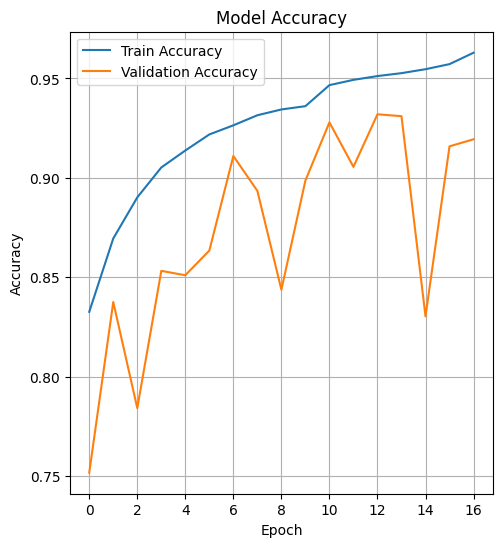

In [19]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print("Training history saved to 'training_history.csv'.")
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [26]:
best_model = tf.keras.models.load_model(checkpoint_filepath)
print("Best model loaded from:", checkpoint_filepath)

Best model loaded from: best_model.keras


188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step


2025-06-23 18:31:49.285848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


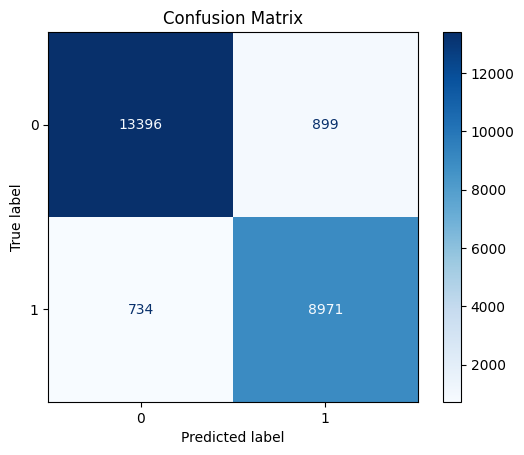

In [27]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = (best_model.predict(val_ds) > 0.5).astype("int32")
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Flatten y_val and y_pred if needed
y_val_flat = y_val.flatten()
y_pred_flat = y_pred.flatten()

accuracy = accuracy_score(y_val_flat, y_pred_flat)
precision = precision_score(y_val_flat, y_pred_flat)
recall = recall_score(y_val_flat, y_pred_flat)
f1 = f1_score(y_val_flat, y_pred_flat)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9320
Precision: 0.9089
Recall:    0.9244
F1 Score:  0.9166


# Exporting Results:

In [31]:
base_test_dir = 'test/'  # specify test data folder
test_files = glob(os.path.join(base_test_dir, '*.tif'))  # find the test file names
submission = pd.DataFrame()  # create a dataframe to hold results
max_idx = len(test_files)  # last index to use
submission['id'] = [os.path.splitext(os.path.basename(f))[0] for f in test_files]
# Load test images
test_images = np.zeros((max_idx, 96, 96, 3), dtype=np.uint8)
for i, file in enumerate(tqdm(test_files, desc="Loading test images")):
    img = cv2.imread(file)
    if img is not None:
        test_images[i] = img
    else:
        print(f"Warning: Failed to load image at {file}")  
# Normalize test images
test_images = test_images.astype(np.float16) / 255.0

Loading test images:   0%|          | 0/57458 [00:00<?, ?it/s]

In [33]:
batch_size = 32  # or even 16 if you still get errors
predictions = []
for i in range(0, len(test_images), batch_size):
    batch = test_images[i:i+batch_size]
    batch_pred = best_model.predict(batch, batch_size=batch_size, verbose=0)
    predictions.append(batch_pred)
predictions = np.vstack(predictions)

In [34]:
# Add predictions to submission DataFrame
submission['label'] = (predictions > 0.5).astype(int)
# Save submission DataFrame to CSV
submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'.")

Submission saved to 'submission.csv'.


In [35]:
submission.label.value_counts()

label
0    36522
1    20936
Name: count, dtype: int64

In [36]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file